In [70]:
import traceback
import sys

try:

    from matplotlib import pyplot as plt #viz
    from termcolor import colored #Colored Text
    import cartopy.crs as ccrs #projected viz
    import matplotlib.colors as colors #colors for viz
    import xarray as xr #process NetCDF
    import numpy as np
    import pandas as pd #data manipulation
    import cartopy
    import matplotlib.gridspec as gridspec #create subplot
    from glob import iglob #data access in file manager
    from os.path import join 
    from functools import reduce #string manipulation
    import itertools #dict manipulation
    import cartopy.feature as cf
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    import matplotlib.patches as mpatches
    
    from datetime import datetime, timedelta
    import time
    import pytz
    
    #Other Viz Packages
    import altair as alt
    import descartes
    import geopandas as gpd
    from shapely.geometry import Point, Polygon
    import plotly.express as px
    
    
except ModuleNotFoundError:

    print(colored('\nModule import error', 'red'), '\n')
    print(traceback.format_exc())

else:
    print(colored('\nAll libraries proeprly loaded!!', 'green'), '\n')
    
    
alt.data_transformers.disable_max_rows()

def flatten_xarray(xarr):
    return np.concatenate([v.values.ravel() for v in xarr])


All libraries proeprly loaded!! 



### Load Files

In [2]:
local_path = '/Users/karthikrameshbabu/MIDS/w210/methane_local/sentinel5p/'
product_path = local_path + 'data/'
input_files = sorted(list(iglob(join(product_path, '**', '*CH4*.nc' ), recursive=True)))
print(colored("CH4 Products Detected", 'blue'), len(input_files))


# s5p_file = input_files[0]
# start_date, end_date = list(filter(lambda x: len(x) == 15, s5p_file.split("_")))

# print(colored("\nProduct selected", 'blue'), s5p_file)
# print(colored("\nProduct start_date", 'blue'), start_date)
# print(colored("\nProduct end_date", 'blue'), end_date)

CH4 Products Detected 49


### Store each scan by datetime range

In [4]:
start = time.time()
s5p_products = {}
for file_name in input_files:
    
    start_date, end_date = list(filter(lambda x: len(x) == 15, file_name.split("_")))
    key = start_date + '::' + end_date
    
#     print(colored("\nProduct selected", 'blue'), s5p_file)
#     print(colored("Product scan range", 'blue'), start_date, '--', end_date)
    
    try:
        #Open product - PRODUCT
        with xr.load_dataset(file_name, group='PRODUCT') as s5p_prod:
            s5p_products[key] = s5p_prod
        s5p_prod.close()
        
    except:
        print(f"FAILED: {key}")
    
end = time.time()
print('Number of files', len(s5p_products), ", load_time:", end-start)

FAILED: 20210806T190833::20210806T205003
Number of files 48 load_time: 14.436377048492432


### Load all into Pandas DF
* Filter at each step otherwise data will be HUGE



In [6]:
#Geo Mask
# Little wider than CA - (lat, lon)
CA_BOUNDARIES = {
    'ul': (41.993207, -124.645155),
    'lr': (32.766491, -113.789407)
}


# #Time Mask
# time_mask_df = (df['time_utc'] > time_lb) & (df['time_utc'] < time_ub)

In [7]:
columns = ['time_utc', 'lat', 'lon', 'qa_val', 'methane_mixing_ratio',
           'methane_mixing_ratio_precision', 'methane_mixing_ratio_bias_corrected']
df_aug_ca = pd.DataFrame(columns=columns)

init_start = time.time()
for file_number, product_key in enumerate(s5p_products, 1):
    s5p_prod = s5p_products[product_key]

    start_time = time.time()
    df_cur_scan = pd.DataFrame(columns=columns)
    times_utc = np.array(s5p_prod.time_utc[0, :])

    print(f'#{file_number} - {product_key}, Starting scan processing')
    for index, ts in enumerate(times_utc, 0):
        lats = np.array(s5p_prod.latitude[0, :, :][index])
        lons = np.array(s5p_prod.longitude[0, :, :][index])
        qa_vals = np.nan_to_num(s5p_prod.qa_value[0, :, :][index], nan=-9999)

        methane_mixing_ratio =  np.nan_to_num(s5p_prod.methane_mixing_ratio[0, :, :][index], nan=-9999)
        methane_mixing_ratio_precision = np.nan_to_num(s5p_prod.methane_mixing_ratio_precision[0, :, :][index], nan=-9999)    
        methane_mixing_ratio_bias_corrected = np.nan_to_num(s5p_prod.methane_mixing_ratio_bias_corrected[0, :, :][index], nan=-9999)

        cur_ts_dict = {
            'time_utc' : [ts] * len(lats),
            'lat' : lats,
            'lon' : lons,
            'qa_val' : qa_vals,
            'methane_mixing_ratio' : methane_mixing_ratio,
            'methane_mixing_ratio_precision' : methane_mixing_ratio_precision,
            'methane_mixing_ratio_bias_corrected' : methane_mixing_ratio_bias_corrected,
        }
        
        df_cur_ts = pd.DataFrame(cur_ts_dict)
        df_cur_scan = pd.concat([df_cur_scan, df_cur_ts], ignore_index=True)


    geo_ca_mask_df = (df_cur_scan.lon > CA_BOUNDARIES['ul'][1]) & \
                  (df_cur_scan.lat < CA_BOUNDARIES['ul'][0]) & \
                  (df_cur_scan.lon < CA_BOUNDARIES['lr'][1]) & \
                  (df_cur_scan.lat > CA_BOUNDARIES['lr'][0])

    qa_thresh = 0.0

    #QA Mask
    qa_mask_df = df_cur_scan['qa_val'] >= qa_thresh


    #Methane Mask
    meth_ca_mask_df = (df_cur_scan.methane_mixing_ratio != -9999) & \
                      (df_cur_scan.methane_mixing_ratio_precision != -9999) & \
                      (df_cur_scan.methane_mixing_ratio_bias_corrected != -9999)

    mask_join_df = geo_ca_mask_df & qa_mask_df & meth_ca_mask_df    
    df_cur_scan_masked = df_cur_scan[mask_join_df]
    end_time = time.time()    
    print(f'#{file_number} - {product_key}, shape: {df_cur_scan_masked.shape}, time taken: {end_time-start_time}')
    print()
    
    df_aug_ca = pd.concat([df_aug_ca, df_cur_scan_masked], ignore_index=True)


print(f'df_aug_ca shape: {df_aug_ca.shape} total_time: {end_time - init_start}')


#1 - 20210801T190234::20210801T204403, Starting scan processing
#1 - 20210801T190234::20210801T204403, shape: (128, 7), time taken: 73.8388500213623

#2 - 20210801T204403::20210801T222533, Starting scan processing
#2 - 20210801T204403::20210801T222533, shape: (1360, 7), time taken: 73.86663699150085

#3 - 20210802T184328::20210802T202458, Starting scan processing
#3 - 20210802T184328::20210802T202458, shape: (0, 7), time taken: 73.25858306884766

#4 - 20210802T202458::20210802T220627, Starting scan processing
#4 - 20210802T202458::20210802T220627, shape: (2693, 7), time taken: 72.55855298042297

#5 - 20210804T194646::20210804T212815, Starting scan processing
#5 - 20210804T194646::20210804T212815, shape: (5452, 7), time taken: 74.79215478897095

#6 - 20210804T212815::20210804T230945, Starting scan processing
#6 - 20210804T212815::20210804T230945, shape: (0, 7), time taken: 72.77918481826782

#7 - 20210805T192740::20210805T210909, Starting scan processing
#7 - 20210805T192740::20210805T2

In [263]:
## Write to CSV
# df_aug_ca.to_csv(local_path +'data/aug_21/aug_21_filtered.csv')

## START HERE IF LOADING FROM LOCAL FILE

In [262]:
# # Read from CSV
# df_aug_ca = pd.read_csv('data/aug_21/aug_21_filtered.csv')
# df_aug_ca.drop('Unnamed: 0', axis=1, inplace=True)
# df_aug_ca.head()

,time_utc,lat,lon,qa_val,methane_mixing_ratio,methane_mixing_ratio_precision,methane_mixing_ratio_bias_corrected
0,2021-08-01T19:57:42.668000Z,32.866806,-114.359250,0.4,1858.0217,1.434432,1860.8737
1,2021-08-01T19:57:43.508000Z,32.799152,-114.617550,0.4,1869.6572,1.434827,1873.1146
2,2021-08-01T19:57:43.508000Z,32.914066,-114.380090,0.4,1850.1168,1.449401,1853.2874
3,2021-08-01T19:57:44.348000Z,32.846360,-114.638510,0.4,1876.0233,1.410911,1878.4884
4,2021-08-01T19:57:47.708000Z,33.035030,-114.722824,0.4,1852.6785,1.527326,1857.2365


In [13]:
#DF Memory
df_aug_ca.info(memory_usage="deep")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98727 entries, 0 to 98726
Data columns (total 7 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   time_utc                             98727 non-null  object 
 1   lat                                  98727 non-null  float32
 2   lon                                  98727 non-null  float32
 3   qa_val                               98727 non-null  float32
 4   methane_mixing_ratio                 98727 non-null  float32
 5   methane_mixing_ratio_precision       98727 non-null  float32
 6   methane_mixing_ratio_bias_corrected  98727 non-null  float32
dtypes: float32(6), object(1)
memory usage: 10.2 MB


<hr>

In [105]:
print(df_aug_ca.dtypes)
print()
print(df_aug_ca.shape)


df_aug_ca.head()


time_utc                                object
lat                                    float32
lon                                    float32
qa_val                                 float32
methane_mixing_ratio                   float32
methane_mixing_ratio_precision         float32
methane_mixing_ratio_bias_corrected    float32
dtype: object

(98727, 7)


,time_utc,lat,lon,qa_val,methane_mixing_ratio,methane_mixing_ratio_precision,methane_mixing_ratio_bias_corrected
0,2021-08-01T19:57:42.668000Z,32.866806,-114.359253,0.4,1858.021729,1.434433,1860.873657
1,2021-08-01T19:57:43.508000Z,32.799152,-114.617554,0.4,1869.657227,1.434826,1873.114624
2,2021-08-01T19:57:43.508000Z,32.914066,-114.380089,0.4,1850.116821,1.449401,1853.287354
3,2021-08-01T19:57:44.348000Z,32.846359,-114.638512,0.4,1876.023315,1.410911,1878.488403
4,2021-08-01T19:57:47.708000Z,33.035030,-114.722824,0.4,1852.678467,1.527326,1857.236450


### `qa_val` EDA

In [25]:
c = df_aug_ca.qa_val.value_counts(dropna=False)
p = df_aug_ca.qa_val.value_counts(dropna=False, normalize=True)
pd.concat([c,p], axis=1, keys=['counts', '%'])

,counts,%
1.0,52365,0.530402
0.4,46362,0.469598


### `methane_mixing_ratio_bias_corrected` EDA

In [198]:
meth_vals = df_aug_ca['methane_mixing_ratio_bias_corrected']

min_methane_ratio = np.min(meth_vals)
max_methane_ratio = np.max(meth_vals)
mean_methane_ratio = np.mean(meth_vals)

print('min', min_methane_ratio)
print('max', max_methane_ratio)
print('mean', np.mean(meth_vals))
print('std', np.std(meth_vals))
print()

bins, step = np.linspace(min_methane_ratio,max_methane_ratio, 25, retstep=True)
print("bins", '\n', bins, '\n')
print("step", '\n', step)


min 1356.797607421875
max 2000.6650390625
mean 1875.511474609375
std 24.393701553344727

bins 
 [1356.79760742 1383.62541707 1410.45322673 1437.28103638 1464.10884603
 1490.93665568 1517.76446533 1544.59227498 1571.42008464 1598.24789429
 1625.07570394 1651.90351359 1678.73132324 1705.55913289 1732.38694255
 1759.2147522  1786.04256185 1812.8703715  1839.69818115 1866.5259908
 1893.35380046 1920.18161011 1947.00941976 1973.83722941 2000.66503906] 

step 
 26.827809651692707


### Understand the distribution

In [93]:
counts, edges = np.histogram(meth_vals, bins)
percents = counts*100/np.sum(counts)

bin_lbs = [] #lower bound
bin_ubs = [] #upper bound

for ind, lb in enumerate(edges, 0):
    if ind < len(edges) - 1:
        bin_lbs.append(lb)
        bin_ubs.append(edges[ind+1])
        
bins_df = pd.DataFrame({"bin_lb": bin_lbs, "bin_ub":bin_ubs, "counts": counts, "%":percents})
bins_df

,bin_lb,bin_ub,counts,%
0,1356.797607,1383.625417,1,0.001013
1,1383.625417,1410.453227,0,0.000000
2,1410.453227,1437.281036,0,0.000000
3,1437.281036,1464.108846,0,0.000000
4,1464.108846,1490.936656,1,0.001013
5,1490.936656,1517.764465,2,0.002026
6,1517.764465,1544.592275,2,0.002026
7,1544.592275,1571.420085,2,0.002026
8,1571.420085,1598.247894,3,0.003039
9,1598.247894,1625.075704,2,0.002026


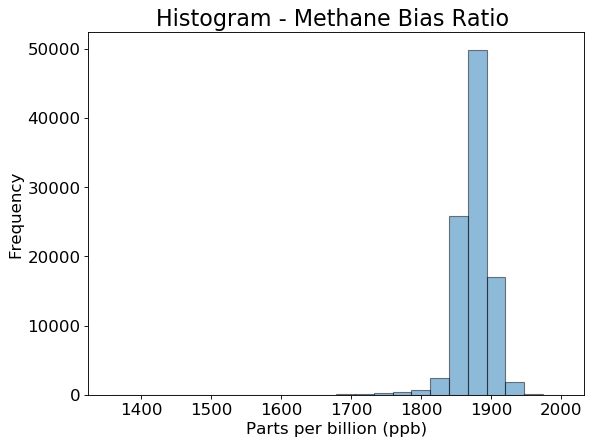

In [100]:
plt.figure(figsize=(8, 6), dpi=80)

plt.title('Histogram - Methane Bias Ratio ',fontsize=20)
plt.xlabel('Parts per billion (ppb)', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

plt.hist(meth_vals, bins, alpha=0.5, histtype='bar', ec='black')

plt.xticks(fontsize = 15) 
plt.yticks(fontsize = 15) 
plt.show() 

### Transformations

#### Datetime format

#### Rounding Off Lat/Lon 

Article about precision: https://en.wikipedia.org/wiki/Decimal_degrees
* 0.1 - large city or district	- 11.1 km
* 0.01 - town or village - 1.11 km ("margin of error")


In [213]:
df_aug_ca['time_utc'] = pd.to_datetime(df_aug_ca['time_utc'], infer_datetime_format= True)

df_aug_ca.insert(3, 'rounded_lat', df_aug_ca['lat'].round())
df_aug_ca.insert(4, 'rounded_lon', df_aug_ca['lon'].round())

df_aug_ca.insert(3, 'rounded_lat_2', df_aug_ca['lat'].round(2))
df_aug_ca.insert(4, 'rounded_lon_2', df_aug_ca['lon'].round(2))

df_aug_ca.insert(3, 'rounded_lat_1', df_aug_ca['lat'].round(1))
df_aug_ca.insert(4, 'rounded_lon_1', df_aug_ca['lon'].round(1))

print("ORIGINAL DATA SHAPE", df_aug_ca.shape)
df_aug_ca.head()

ORIGINAL DATA SHAPE (98727, 13)


,time_utc,lat,lon,rounded_lat,rounded_lon,rounded_lat_1,rounded_lon_1,rounded_lat_2,rounded_lon_2,qa_val,methane_mixing_ratio,methane_mixing_ratio_precision,methane_mixing_ratio_bias_corrected
0,2021-08-01 19:57:42.668,32.866806,-114.359253,33.0,-114.0,32.900002,-114.400002,32.869999,-114.360001,0.4,1858.021729,1.434433,1860.873657
1,2021-08-01 19:57:43.508,32.799152,-114.617554,33.0,-115.0,32.799999,-114.599998,32.799999,-114.620003,0.4,1869.657227,1.434826,1873.114624
2,2021-08-01 19:57:43.508,32.914066,-114.380089,33.0,-114.0,32.900002,-114.400002,32.910000,-114.379997,0.4,1850.116821,1.449401,1853.287354
3,2021-08-01 19:57:44.348,32.846359,-114.638512,33.0,-115.0,32.799999,-114.599998,32.849998,-114.639999,0.4,1876.023315,1.410911,1878.488403
4,2021-08-01 19:57:47.708,33.035030,-114.722824,33.0,-115.0,33.000000,-114.699997,33.040001,-114.720001,0.4,1852.678467,1.527326,1857.236450


### Group By - Lat/Lon

In [154]:
gdf_geo_1 = df_aug_ca.groupby(['rounded_lat_1', 'rounded_lon_1']) \
                 .agg({'methane_mixing_ratio_bias_corrected':['mean', 'min','max']})


gdf_geo_2 = df_aug_ca.groupby(['rounded_lat_2', 'rounded_lon_2']) \
                 .agg({'methane_mixing_ratio_bias_corrected':['mean', 'min','max']})


print('gdf_geo_1', gdf_geo_1.shape)
print('gdf_geo_2', gdf_geo_2.shape)

gdf_geo_1 (5768, 3)
gdf_geo_2 (82922, 3)


### Group By - Date/Time

In [155]:
gdf_date = df_aug_ca.groupby([df_aug_ca.time_utc.dt.date]) \
                 .agg({'methane_mixing_ratio_bias_corrected':['mean', 'min','max']})

print('gdf_date', gdf_date.shape)

gdf_date (30, 3)


In [157]:
gdf_date_date_hour = df_aug_ca.groupby([df_aug_ca.time_utc.dt.date, df_aug_ca.time_utc.dt.hour]) \
                 .agg({'methane_mixing_ratio_bias_corrected':['mean', 'min','max']})

print('gdf_date_date_hour', gdf_date_date_hour.shape)

gdf_date_date_hour (42, 3)


### Group By - Both

In [158]:
gdf_both_1 = df_aug_ca.groupby([df_aug_ca.time_utc.dt.date, 'rounded_lat_1', 'rounded_lon_1']) \
                 .agg({'methane_mixing_ratio_bias_corrected':['mean', 'min','max']})


gdf_both_2 = df_aug_ca.groupby([df_aug_ca.time_utc.dt.date, 'rounded_lat_2', 'rounded_lon_2']) \
                 .agg({'methane_mixing_ratio_bias_corrected':['mean', 'min','max']})

print('gdf_both_1', gdf_both_1.shape)
print('gdf_both_2', gdf_both_2.shape) # This is useless


gdf_both_1 (61698, 3)
gdf_both_2 (98720, 3)


### Playing around with Latitude regions

Because California is a really "tall and skinny" state I wanted to see what the methane spread looks like when dividing into latitude chunks

* Refer to this image https://upload.wikimedia.org/wikipedia/commons/thumb/e/e1/California_Topography-MEDIUM.png/1280px-California_Topography-MEDIUM.png

1.0 latitude degree - represents 111 km --> 68.97 miles

In [218]:
gdf_lat = df_aug_ca.groupby([df_aug_ca.time_utc.dt.date, 'rounded_lat'])['methane_mixing_ratio_bias_corrected'] \
                        .mean() \
                        .reset_index()

gdf_lat["time_utc"] = pd.to_datetime(gdf_lat["time_utc"])

gdf_lat_1 = df_aug_ca.groupby([df_aug_ca.time_utc.dt.date, 'rounded_lat_1'])['methane_mixing_ratio_bias_corrected'] \
                        .mean() \
                        .reset_index()

gdf_lat_1["time_utc"] = pd.to_datetime(gdf_lat_1["time_utc"])



print('gdf_lat', gdf_lat.shape)
print('gdf_lat_1', gdf_lat_1.shape)



gdf_lat (292, 3)
gdf_lat_1 (2645, 3)


### Graphs

In [189]:
gdf_date_mean = df_aug_ca.groupby([df_aug_ca.time_utc.dt.date])['methane_mixing_ratio_bias_corrected'] \
                        .mean() \
                        .reset_index()

gdf_date_mean["time_utc"] = pd.to_datetime(gdf_date_mean["time_utc"])

In [207]:
monthly_min = alt.Chart(pd.DataFrame({'y': [min_methane_ratio]})).mark_rule(color='red').encode(y='y')
monthly_mean = alt.Chart(pd.DataFrame({'y': [mean_methane_ratio]})).mark_rule( color='green').encode(y='y')
monthly_max = alt.Chart(pd.DataFrame({'y': [max_methane_ratio]})).mark_rule( color='orange').encode(y='y')

line_chart = alt.Chart(gdf_date_mean, title ="CA - August 2021 Daily Average").mark_line(point=True, tooltip=True).encode(
    alt.X('time_utc:T', title= "Date"),    
    alt.Y('methane_mixing_ratio_bias_corrected:Q'
    , scale=alt.Scale(zero=False))
).interactive()


line_chart + monthly_mean #+monthly_max + monthly_min 



alt.LayerChart(...)

<hr>

In [216]:
gdf_lat.head()

,time_utc,rounded_lat,methane_mixing_ratio_bias_corrected
0,2021-08-01,33.0,1864.246338
1,2021-08-01,34.0,1868.584839
2,2021-08-01,35.0,1864.816772
3,2021-08-01,36.0,1869.477173
4,2021-08-01,37.0,1872.537720


In [241]:
point = 0 # or 1
tooltip = True if point else False

highlight = alt.selection(type='single', on='mouseover',
                          fields=['rounded_lat'], nearest=True)

base = alt.Chart(gdf_lat, title ="Latitude - August 2021 Daily Average").encode(
    alt.X('time_utc:T', title= "Date"),  
    alt.Y('methane_mixing_ratio_bias_corrected:Q'
    , scale=alt.Scale(zero=False)),
    color='rounded_lat:N'
)

points = base.mark_circle(tooltip=tooltip).encode(
    opacity=alt.value(point)
).add_selection(
    highlight
).properties(
    width=600,
    height= 400
)

lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1), alt.value(3))
)

points + lines


alt.LayerChart(...)

In [251]:
alt.Chart(gdf_lat, title = "Latitude Degree overv time Aug 2021").mark_rect(tooltip=True, stroke='white', strokeWidth=2).encode(
    x='time_utc:O',
    y='rounded_lat:O',
    color='methane_mixing_ratio_bias_corrected:Q'
)

alt.Chart(...)